In [ ]:
import csv
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from dataclasses import dataclass

In [ ]:
import pandas as pd

In [ ]:
data = pd.read_csv('EURUSD1440.csv')

In [ ]:
data.head(1)

,Date,Time,Open,High,Low,Close,Volume
0,2012.12.10,0:00,1.29054,1.29454,1.28847,1.29358,122544


In [ ]:
data.tail(2)

,Date,Time,Open,High,Low,Close,Volume
1849,2020.06.29,0:00,1.12186,1.12874,1.12165,1.12410,149760
1850,2020.06.30,0:00,1.12409,1.12515,1.11993,1.12031,52087


In [ ]:
values = data['Open'].values

In [ ]:
values

array([1.29054, 1.29358, 1.29671, ..., 1.12171, 1.12186, 1.12409])

In [ ]:
len(values)

1851

In [ ]:
train = values[:int(len(values)*0.9)]
test = values[int(len(values)*0.9):]

In [ ]:
def windowed_dataset(series, window_size, batch_size, 
                     shuffle_buffer):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    ds = ds.batch(batch_size).prefetch(1)
    return ds

In [ ]:
train_ds = windowed_dataset(train, 30, 5, 1000)
test_ds = windowed_dataset(test, 30, 5, 1000)

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters = 64, kernel_size = 3, 
                            padding='causal', strides=1,
                            activation='relu', input_shape=[30, 1]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(30, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1)    
]) 

In [ ]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20)
)

In [ ]:
model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=tf.keras.optimizers.SGD(momentum=0.9), 
                  metrics=["mae"])

In [ ]:
history = model.fit(train_ds, validation_data=test_ds, 
                    epochs=100, callbacks=[lr_schedule])

Epoch 1/100
332/332 [==============================] - 19s 17ms/step - loss: 0.6904 - mae: 1.1904 - val_loss: 0.6121 - val_mae: 1.1121 - lr: 1.0000e-08
Epoch 2/100
332/332 [==============================] - 5s 14ms/step - loss: 0.6903 - mae: 1.1903 - val_loss: 0.6120 - val_mae: 1.1120 - lr: 1.1220e-08
Epoch 3/100
332/332 [==============================] - 4s 12ms/step - loss: 0.6902 - mae: 1.1902 - val_loss: 0.6119 - val_mae: 1.1119 - lr: 1.2589e-08
Epoch 4/100
332/332 [==============================] - 4s 12ms/step - loss: 0.6901 - mae: 1.1901 - val_loss: 0.6118 - val_mae: 1.1118 - lr: 1.4125e-08
Epoch 5/100
332/332 [==============================] - 4s 13ms/step - loss: 0.6900 - mae: 1.1900 - val_loss: 0.6117 - val_mae: 1.1117 - lr: 1.5849e-08
Epoch 6/100
332/332 [==============================] - 4s 13ms/step - loss: 0.6898 - mae: 1.1898 - val_loss: 0.6115 - val_mae: 1.1115 - lr: 1.7783e-08
Epoch 7/100
332/332 [==============================] - 5s 14ms/step - loss: 0.6896 - mae: 1.1

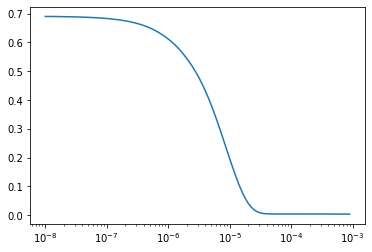

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
# plt.axis([1e-8, 10, 0, 10])

In [ ]:
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9),
              metrics=["mae"]) 

In [ ]:
history2 = model.fit(train_ds, validation_data=test_ds, epochs=100)

Epoch 1/100
327/327 [==============================] - 94s 56ms/step - loss: 0.0092 - mae: 0.0728 - val_loss: 4.1876e-04 - val_mae: 0.0257
Epoch 2/100
327/327 [==============================] - 17s 50ms/step - loss: 7.9361e-04 - mae: 0.0314 - val_loss: 1.0617e-04 - val_mae: 0.0116
Epoch 3/100
327/327 [==============================] - 17s 50ms/step - loss: 2.4306e-04 - mae: 0.0173 - val_loss: 1.4203e-04 - val_mae: 0.0128
Epoch 4/100
327/327 [==============================] - 16s 49ms/step - loss: 1.6716e-04 - mae: 0.0142 - val_loss: 2.6947e-04 - val_mae: 0.0191
Epoch 5/100
327/327 [==============================] - 16s 49ms/step - loss: 1.5740e-04 - mae: 0.0137 - val_loss: 1.0530e-04 - val_mae: 0.0115
Epoch 6/100
327/327 [==============================] - 17s 53ms/step - loss: 1.8979e-04 - mae: 0.0150 - val_loss: 1.2760e-04 - val_mae: 0.0121
Epoch 7/100
327/327 [==============================] - 15s 47ms/step - loss: 1.4978e-04 - mae: 0.0133 - val_loss: 1.0849e-04 - val_mae: 0.0114
Epo

In [54]:
model.save('EURUSD1440.h5')